In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from modules import AEC_builder

import os
# GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='5'

nb_layer = 1
_encoder = AEC_builder.Encoder(input_shape=(2000, 16, 1), nb_layer=nb_layer, padding='same', kernel_size=(10,3), strides=(1,1), pool_size=(5,3), pool_strides=(2,2))
_encoder.build()

if not(_encoder.error_shape):
    model = _encoder.model
    model.summary()

    # _bottle_neck = AEC_builder.BottleNeck(_encoder=_encoder.model, use_DENSE_OR_GAP='DENSE')
    # _bottle_neck.build()
    # model2 = _bottle_neck.model
    # model2.summary()
    
    # model3 = _bottle_neck.decoder
    # model3.summary()

    # _decoder = AEC_builder.Decoder(_bottleneck=_bottle_neck.decoder, nb_layer=nb_layer, use_UPSAMPLE_OR_DECONV='UPSAMPLE', padding='same', kernel_size=(10,3), strides=(2,2), pool_size=(2, 2))
    # _decoder.build()
    # model4 = _decoder.model
    # model4.summary()

In [ ]:
a = model.output
b = Flatten()(a)
b = Dense(b.shape[1])(b)
c = Model(inputs=model.input, outputs=b)
c.summary()

In [ ]:
import os
import pandas as pd
from modules.utils import append_default_path
from modules import AEC_builder

def getTupleFromStr(_str):
    width = _str.split(',')[0]
    height = _str.split(',')[1]
    
    width = int(width.split('(')[1])
    height = int(height.split(')')[0])
    
    return (width, height)

def get_ExperimentInfo():
    path_module, path_csv, path_scalogram = append_default_path()
    df_experiment = pd.read_excel(os.path.join(path_csv, 'AEC_experiments.xlsx'), index_col=0)
    return df_experiment

def get_PARAMS_from_ExperimentInfo(temp_experiment):
    encoder_PARAMS = {
        'nb_layer' : temp_experiment['nb_layer'],
        'kernel_size' : (temp_experiment['kernel_width'], (temp_experiment['kernel_height'])),
        'strides' : (temp_experiment['strides_width'], temp_experiment['strides_height']),
        'padding' : temp_experiment['padding'],
        'act_selection' : temp_experiment['act_selection'],
        'pool_size' : (temp_experiment['max_pool_width'], temp_experiment['max_pool_height']),
        'pool_strides' : (temp_experiment['max_pool_strides_width'], temp_experiment['max_pool_strides_height'])   
    }
    
    bottleneck_PARAMS = {
        'vector_len' : temp_experiment['vector_len'],
        'act_selection' : temp_experiment['act_selection'],
        'use_DENSE_OR_GAP' : temp_experiment['use_DENSE_OR_GAP']
    }
    
    decoder_PARAMS = {
        'nb_layer' : temp_experiment['nb_layer'],
        'use_UPSAMPLE_OR_DECONV' : temp_experiment['use_UPSAMPLE_OR_DECONV'],
        'kernel_size' : (temp_experiment['decoder_kernel_width'], temp_experiment['decoder_kernel_height']),
        'strides' : (temp_experiment['decoder_strides_width'], temp_experiment['decoder_strides_height']),
        'padding' : temp_experiment['padding'],
        'act_selection' : temp_experiment['act_selection'],
        'pool_size' : (temp_experiment['decoder_pool_width'], temp_experiment['decoder_pool_height'])        
    }

    return encoder_PARAMS, bottleneck_PARAMS, decoder_PARAMS


def get_model_with_experiment_info(temp_experiment):
    encoder_PARAMS, bottleneck_PARAMS, decoder_PARAMS = get_PARAMS_from_ExperimentInfo(temp_experiment)
    _encoder = AEC_builder.Encoder(**encoder_PARAMS)
    _encoder.build()
    
    bottleneck_PARAMS['_encoder'] = _encoder.model
    _bottle_neck = AEC_builder.BottleNeck(**bottleneck_PARAMS)
    _bottle_neck.build()
    
    decoder_PARAMS['_bottleneck'] = _bottle_neck.decoder
    _decoder = AEC_builder.Decoder(**decoder_PARAMS)
    _decoder.build()
    
    return _decoder.model
    

df_experiment = get_ExperimentInfo()
display(df_experiment)

model = get_model_with_experiment_info(df_experiment.loc[2, :])

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, UpSampling2D, Dropout
from tensorflow.keras.layers import Conv3D, Conv3DTranspose, PReLU, BatchNormalization, MaxPool3D, Input, Conv2D, Conv2DTranspose, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

def ConvolutionalAutoencoder_v05(vector_len=30):
    weight_decay=0.0005

    model = Sequential()
    model.add(Conv2D(filters=24,
                        input_shape=(2000, 16, 1),
                        kernel_size=(10, 2),
                        strides=(1, 1),
                        kernel_regularizer=regularizers.l2(l=weight_decay),
                        padding='valid', name="Conv1"))
    model.add(BatchNormalization(name="BN1"))
    model.add(PReLU(name="PReLU1"))

    model.add(Conv2D(filters=48,
                        kernel_size=(10, 2),
                        strides=(2, 1),
                        kernel_regularizer=regularizers.l2(l=weight_decay),
                        padding='valid', name="Conv2"))
    model.add(BatchNormalization(name="BN2"))
    model.add(PReLU(name="PReLU2"))

    model.add(MaxPool2D(pool_size=(5, 2),
                        strides=(2, 1), name="Pool1"))

    model.add(Flatten())
    model.add(Dense(units=vector_len, name='embedding'))

    model.add(Dense(units=494*14*48, activation='relu'))

    model.add(Reshape((494,14,48)))

    model.add(Conv2DTranspose(filters=24,
                                kernel_size=(10, 2),
                                kernel_regularizer=regularizers.l2(
                                    l=weight_decay),
                                strides=(2, 1), name="Deconv1", padding='valid'))
    model.add(BatchNormalization(name="BN3"))
    model.add(PReLU(name="PReLU3"))
    model.add(Conv2DTranspose(filters=1,
                                kernel_size=(10, 2),
                                kernel_regularizer=regularizers.l2(
                                    l=weight_decay),
                                strides=(2, 1), name="Deconv2", padding='valid'))
    model.add(BatchNormalization(name="BN4"))
    
    return model

model_v05 = ConvolutionalAutoencoder_v05()
model_v05.summary()

In [ ]:
a = model.output



In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/home/yschoi/INS_Clustering/Deep_clustering_v02/results/1/weights.h5')

In [ ]:
import numpy as np
train_data = np.load('./data'+'/np_scalograms_1ch_train.npy')
test_data = np.load('./data'+'/np_scalograms_1ch_test.npy')



In [ ]:
import pandas as pd



In [ ]:
from modules.AEC_builder import ConvolutionalAutoencoder_v06
model = ConvolutionalAutoencoder_v06()
model.summary()

In [1]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Input
from modules.model_utils import corr_keras
import numpy as np

get_custom_objects().update({'corr_keras':corr_keras})

model = load_model('/home/yschoi/INS_Clustering/Deep_clustering_v02/results/v05/5/weights.h5')
embedding_model = Model(inputs=model.input, outputs=model.get_layer('embedding').output)
# embedding_to_decoder = Model(inputs=model.get_layer('embedding').output, outputs=model.get_layer('BN4').output)
encoded = Input(shape=(50,))

decoded = encoded
for i in range(7):
    decoded = model.layers[i-7](decoded)
embedding_to_decoder = Model(inputs=encoded, outputs=decoded)

train_data = np.load('./data/np_scalograms_1ch_train.npy')
embeddings = embedding_model.predict(train_data)

2023-03-07 22:25:13.346317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-07 22:25:15.093669: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-07 22:25:15.094554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-07 22:25:20.387674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:60:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-03-07 22:25:20.389309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:61:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-03-07 22:2

In [2]:
def getDistance_against_centroid(embeddings, class_idx, centroid):
    distances = []
    for i in range(len(class_idx)):
        distances.append(np.linalg.norm(embeddings[class_idx][i] - centroid))
        
    return distances


def align_scalograms(num_clusters, ord_temp_cluster, axs, fig, embeddings, class_idx, total_idx, centroids):
    distances = getDistance_against_centroid(embeddings=embeddings, class_idx=class_idx, centroid=centroids[ord_temp_cluster])
    dist_idx = np.argsort(distances)
    
    for i in range(10):
        temp_ax = axs[i+1][ord_temp_cluster]
        plot_scalograms(scalogram=train_data[total_idx[class_idx[dist_idx[int(np.floor(len(dist_idx)*0.1*i))]]]], ax=temp_ax, fig=fig)
                        # title='%d%% close' % i*10)

number of class0: 338
number of class1: 29
number of class2: 81
number of class3: 116


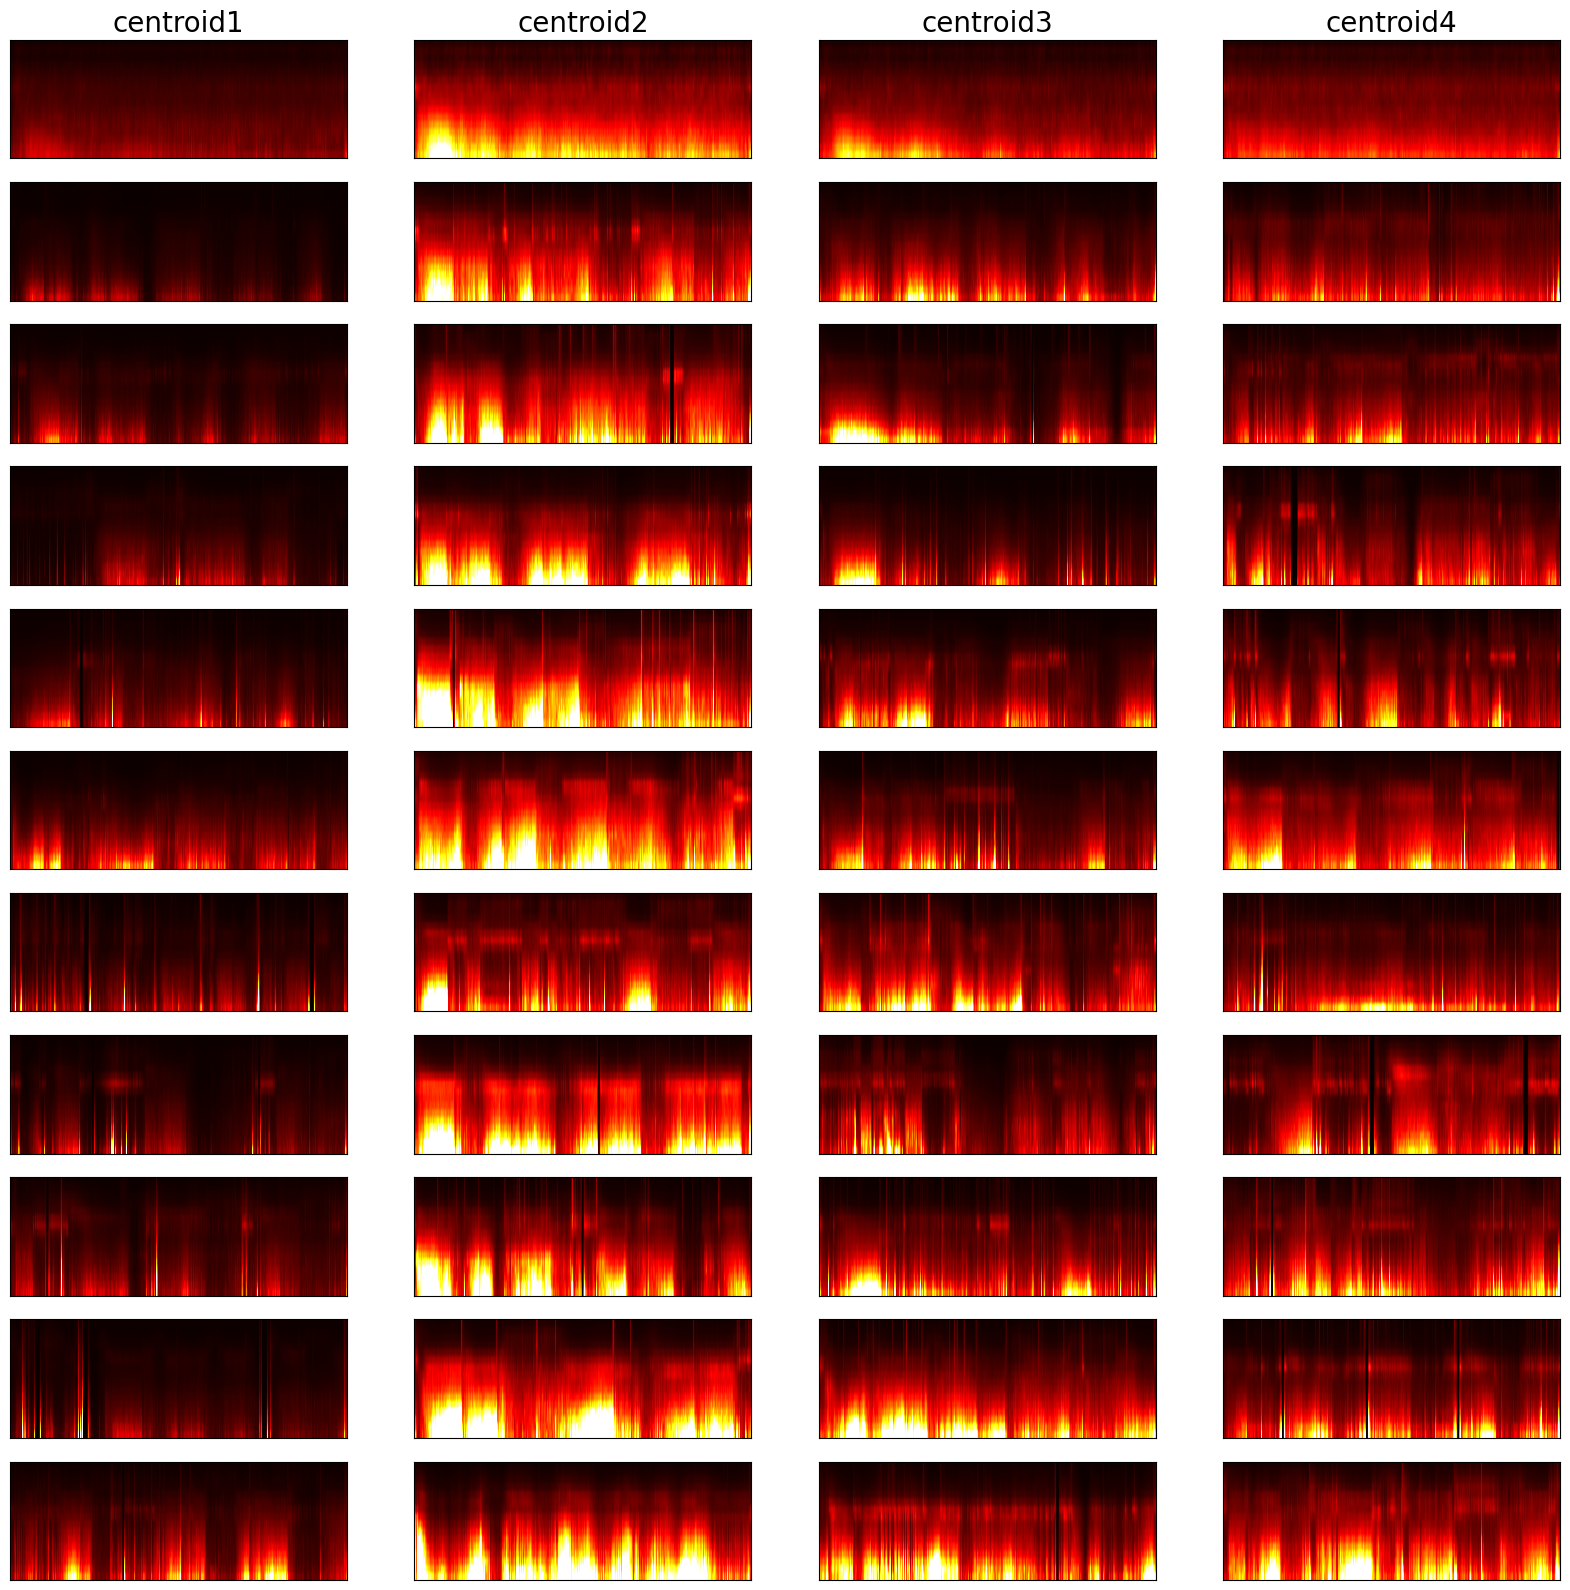

In [5]:
from sklearn.cluster import KMeans
from modules.utils import plot_scalograms
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt



# n_clusters = [2, 3, 4, 5, 6, 7, 8]
n_clusters = [4]#, 4, 5, 6, 7, 8]
for i_cluster in range(len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[i_cluster], max_iter=1000, algorithm='elkan')
    kmeans.fit(embeddings)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    total_idx = np.arange(len(labels))
    idx_class0 = total_idx[labels == 0]
    idx_class1 = total_idx[labels == 1]
    idx_class2 = total_idx[labels == 2]
    idx_class3 = total_idx[labels == 3]
    class_idx = [idx_class0, idx_class1, idx_class2, idx_class3]

    print("number of class0: {}".format(len(idx_class0)))
    print("number of class1: {}".format(len(idx_class1)))
    print("number of class2: {}".format(len(idx_class2)))
    print("number of class3: {}".format(len(idx_class3)))

    # 10%, 20%, 30%, ..., 100%까지 각각 subplot
    fig, axs = plt.subplots(11, 4, figsize=(20,20))

    # centroid plotting
    scalogram_centroids = []
    for i in range(n_clusters[i_cluster]):
        scalogram_centroids.append(embedding_to_decoder.predict(centroids[i].reshape((1,50))))
        plot_scalograms(scalogram=scalogram_centroids[i], ax=axs[0][i], fig=fig, title='centroid'+str(i+1))
        
        align_scalograms(num_clusters=n_clusters[i_cluster], ord_temp_cluster=i, axs=axs, fig=fig, embeddings=embeddings, class_idx=class_idx[i], total_idx=total_idx, centroids=centroids)
        
    
    
    
    
    # plot_scalograms(scalogram_centroids)

In [ ]:
embedding_c0 = embeddings[idx_class0]
embedding_c0.shape

In [ ]:
def getDistance_against_centroid(embeddings, class_idx, centroid):
    distances = []
    for i in range(len(class_idx)):
        distances.append(np.linalg.norm(embeddings[class_idx][i] - centroid))
        
    return distances


def align_scalograms(num_clusters, ord_temp_cluster, axs, fig, embeddings, class_idx, total_idx, centroids):
    distances = getDistance_against_centroid(embeddings=embeddings, class_idx=class_idx, centroid=centroids[ord_temp_cluster])
    dist_idx = np.argsort(distances)
    
    for i in range(10):
        temp_ax = axs[i+1][ord_temp_cluster]
        plot_scalograms(scalogram=train_data[total_idx[class_idx[dist_idx[int(np.floor(len(dist_idx)*0.1*i))]]]], ax=temp_ax, fig=fig)
        

In [ ]:
embedding_c0 = embeddings[idx_class0]
# embedding_c1 = embeddings[class1]
# embedding_c2 = embeddings[class2]
# embedding_c3 = embeddings[class3]

distance_c0 = []
for i in range(len(embedding_c0)):
    distance_c0.append(np.linalg.norm(embedding_c0[i] - centroids[0]))

distance_c0 = np.array(distance_c0)
dist_idx = np.argsort(distance_c0)
print(len(distance_c0))
print(len(dist_idx))
distance_c0[dist_idx]

dist_0 = dist_idx[0]
dist_10 = dist_idx[int(np.floor(len(dist_idx)*0.1))]
dist_20 = dist_idx[int(np.floor(len(dist_idx)*0.2))]

distance_c0[dist_20]

In [ ]:
distance_c0[dist_idx]

In [ ]:
len(distance_c0)

In [ ]:
np.linalg.norm(embedding_c0[0] - centroids[0])

In [ ]:
from scipy.spatial import distance
distance.euclidean(np.array([1,1,1]), np.array([2,3,1]))
distance.euclidean(embedding_c0, centroids[0])

In [ ]:
embedding_c0[0].squeeze().shape
np.array([1,1,1]).shape

In [ ]:
distance_c0

In [ ]:
distance_c0.shape

In [ ]:
dist_idx

In [ ]:
a = np.array([2,3,1])
a[np.argsort(a)]

In [ ]:
class0 = (labels == 0)
class1 = (labels == 1)

In [ ]:
from sklearn.cluster import KMeans
from modules.utils import plot_scalograms
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt

n_clusters = [2, 3, 4, 5, 6, 7, 8]
for i_cluster in range(len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[i_cluster])
    kmeans.fit(embeddings)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    scalogram_centroids = []
    for i in range(n_clusters[i_cluster]):
        scalogram_centroids.append(embedding_to_decoder.predict(centroids[i].reshape((1,50))))
    plot_scalograms(scalogram_centroids)
        
    covariances = []
    for i in range(len(centroids)):
        cluster_points = embeddings[labels == i]
        cluster_covariance = np.cov(cluster_points.T)
        covariances.append(cluster_covariance)

    gmm = GaussianMixture(n_components=n_clusters[i_cluster], covariance_type='full', max_iter=10000, verbose=True, tol=1e-6)
    # gmm.means_init = centroids
    # gmm.precisions_init = np.linalg.inv(covariances)
    gmm.fit(embeddings)
    
    _gmm_centroids = gmm.means_

    scalogram_centroids = []
    for i in range(n_clusters[i_cluster]):
        scalogram_centroids.append(embedding_to_decoder.predict(_gmm_centroids[i].reshape((1,50))))
    plot_scalograms(scalogram_centroids)
    
    from sklearn.manifold import TSNE
    a = gmm.predict_proba(embeddings)
    b = a.argmax(axis=1)

    df = pd.DataFrame(data=b, columns=['target'])
    print(df['target'].value_counts())
    tsne = TSNE(n_components=3, perplexity=2.0, learning_rate=100.0, n_iter=5000, n_iter_without_progress=60, random_state=43, method='barnes_hut')
    tsne_np = tsne.fit_transform(embeddings)
    tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1', 'component 2'])

    from mpl_toolkits.mplot3d import Axes3D

    # 3차원 그래프 세팅
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    # class target 정보 불러오기 
    tsne_df['target'] = df['target']

    # target 별 분리
    tsne_df_0 = tsne_df[tsne_df['target'] == 0]
    tsne_df_1 = tsne_df[tsne_df['target'] == 1]
    tsne_df_2 = tsne_df[tsne_df['target'] == 2]
    tsne_df_3 = tsne_df[tsne_df['target'] == 3]
    tsne_df_4 = tsne_df[tsne_df['target'] == 4]
    tsne_df_5 = tsne_df[tsne_df['target'] == 5]

    # target 별 시각화
    ax.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], tsne_df_0['component 2'], color = 'pink', label = 'subtype1')
    ax.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], tsne_df_1['component 2'], color = 'purple', label = 'subtype2')
    ax.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], tsne_df_2['component 2'], color = 'yellow', label = 'subtype3')
    ax.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], tsne_df_3['component 2'], color = 'red', label = 'subtype4')
    ax.scatter(tsne_df_4['component 0'], tsne_df_4['component 1'], tsne_df_4['component 2'], color = 'green', label = 'subtype5')
    ax.scatter(tsne_df_5['component 0'], tsne_df_5['component 1'], tsne_df_5['component 2'], color = 'black', label = 'subtype6')


    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')
    ax.legend()
    plt.show()


    tsne = TSNE(n_components=2, perplexity=2.0, learning_rate=100.0, n_iter=5000, n_iter_without_progress=60, random_state=43, method='barnes_hut')

    # Fit and transform the data to the 2D t-SNE space
    X_tsne = tsne.fit_transform(embeddings)

    # Plot the t-SNE result
    import matplotlib.pyplot as plt
    scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df.target)
    plt.legend(handles=scatter.legend_elements()[0], labels=list(range(n_clusters[i_cluster])))
    plt.show()